Testing how this looks. So far is seems good!

Distribution 1:
Mean: 18.68229200300492
Median: 18.63291781141136
Distribution 2:
Mean: 18.69191221249503
Median: 15.747066560700272


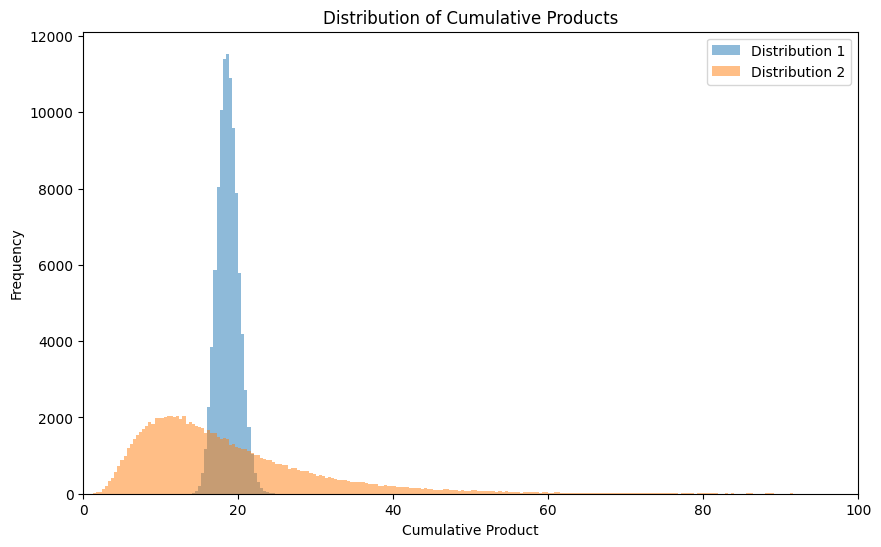

In [19]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)  # Set a random seed for reproducibility

# Parameters for the first distribution
mu1 = 1.05
sigma1 = 0.01

# Parameters for the second distribution
mu2 = 1.05
sigma2 = 0.08

num_simulations = 100000

# Simulate and calculate cumulative products for the first distribution
cumulative_products1 = np.cumprod(np.random.normal(mu1, sigma1, (num_simulations, 60)), axis=1)
mean1 = np.mean(cumulative_products1[:,59])
median1 = np.median(cumulative_products1[:,59])

# Simulate and calculate cumulative products for the second distribution
cumulative_products2 = np.cumprod(np.random.normal(mu2, sigma2, (num_simulations, 60)), axis=1)
mean2 = np.mean(cumulative_products2[:,59])
median2 = np.median(cumulative_products2[:,59])

print("Distribution 1:")
print("Mean:", mean1)
print("Median:", median1)

print("Distribution 2:")
print("Mean:", mean2)
print("Median:", median2)

# plot
plt.figure(figsize=(10, 6))
plt.hist(cumulative_products1[:, 59], bins=500, range=(np.min(cumulative_products2[:, 59]), np.max(cumulative_products2[:, 59])), alpha=0.5, label='Distribution 1')
plt.hist(cumulative_products2[:, 59], bins=500, range=(np.min(cumulative_products2[:, 59]), np.max(cumulative_products2[:, 59])), alpha=0.5, label='Distribution 2')
plt.xlabel('Cumulative Product')
plt.ylabel('Frequency')
plt.xlim([0,100])
plt.title('Distribution of Cumulative Products')
plt.legend()
plt.show()


Sorting out the tax calculation on the data frame

In [6]:
import pandas as pd
import numpy as np

variables = ['robert_income', 'isabel_income', 'expenses', 'assets']

# create initial setup DataFrame
data = pd.DataFrame({
    'year': [2023],
    'robert_income': [100000],
    'isabel_income': [200000],
    'expenses': [50000],
    'assets': [800000]
}).set_index('year')

growth_assumptions = {
    'robert_income': 0.0,
    'isabel_income': 0.0,
    'expenses': 0.01,
    'assets': 0.04
}
shocks = {
    2027: {
        'robert_income': -10000,
        'isabel_income': -100000
    },
    2030: {
        'expenses':30_000
    }

}
volatility = 0.08  # standard deviation of asset growth
simulations = 1000  # number of simulations

# create a DataFrame to hold the future projections
projection = pd.DataFrame(index=range(2023, 2083))

# initialize a DataFrame with simulations for assets
asset_simulations = pd.DataFrame(1 + volatility * np.random.standard_normal(size=(60,10000)), 
                                 index=projection.index,
                                 columns=['simulation_'+str(i) for i in range(10000)]
)

# chain all 
asset_simulations = asset_simulations.cumprod()

# loop over years
for year in projection.index:
    if year == 2023:
        # handle base year
        for var in variables:
            projection.loc[year, var] = data.loc[2023, var]
            asset_simulations.loc[year] = data.loc[2023, 'assets']
    else:
        # apply growth assumptions and shocks
        for var in variables:
            projection.loc[year, var] = projection.loc[year - 1, var] * (1 + growth_assumptions[var])
            if year in shocks and var in shocks[year]:
                shock = shocks[year][var]
                projection.loc[year, var] += shock

        # calculate savings
        projection.loc[year, 'savings'] = projection.loc[year, 'robert_income'] + projection.loc[year, 'isabel_income'] - projection.loc[year, 'expenses']

        # add savings to assets
        projection.loc[year, 'assets'] += projection.loc[year, 'savings']

        # add volatility to assets
        asset_simulations.loc[year] = projection.loc[year - 1, 'assets'] * (asset_simulations.loc[year])



In [8]:
projection.head()

,robert_income,isabel_income,expenses,assets,savings
2023,100000.0,200000.0,50000.0000,8.000000e+05,NaN
2024,100000.0,200000.0,50500.0000,1.081500e+06,249500.0000
2025,100000.0,200000.0,51005.0000,1.373755e+06,248995.0000
2026,100000.0,200000.0,51515.0500,1.677190e+06,248484.9500
2027,90000.0,100000.0,52030.2005,1.882248e+06,137969.7995


In [ ]:
projection['household_income'] = projection['robert_income'] + projection['isabel_income']

In [1]:
def calculate_tax(income):
    brackets = [9950, 40525, 86375, 164925, 209425, 523600]
    rates = [0.10, 0.12, 0.22, 0.24, 0.32, 0.35, 0.37]
    tax = 0

    for i in range(len(brackets)):
        if income > brackets[i]:
            if i == 0:
                tax += rates[i] * brackets[i]
            else:
                tax += rates[i] * (brackets[i] - brackets[i-1])
        else:
            if i == 0:
                tax += rates[i] * income
            else:
                tax += rates[i] * (income - brackets[i-1])
            break

    if income > brackets[-1]:
        tax += rates[-1] * (income - brackets[-1])

    return tax

In [9]:
projection.apply(calculate_tax)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [10]:
import numpy as np

def square(x):
    return x ** 2

square_vectorized = np.vectorize(square)

# Original square function applied to a single value
result = square(5)
print(result)  # Output: 25

# Vectorized version of square function applied to an array
array = np.array([1, 2, 3, 4, 5])
result_array = square_vectorized(array)
print(result_array)  # Output: [ 1  4  9 16 25 ]


25
[ 1  4  9 16 25]


In [11]:
import numpy as np

@np.vectorize
def square(x):
    return x ** 2

# Original square function applied to a single value
result = square(5)
print(result)  # Output: 25

# Vectorized version of square function applied to an array
array = np.array([1, 2, 3, 4, 5])
result_array = square_vectorized(array)
print(result_array)  # Output: [ 1  4  9 16 25 ]

25
[ 1  4  9 16 25]


In [1]:
shocks = {
    2027: {
        'robert_income': (-10000, 'Robert leaves Google'),
        'isabel_income': (-100000, 'Isabel book deals are smaller')
    },
    2030: {
        'expenses':(30_000, 'Childcare')
    }

}

In [4]:
test = [item for item in shocks.items()]
test

[(2027,
  {'robert_income': (-10000, 'Robert leaves Google'),
   'isabel_income': (-100000, 'Isabel book deals are smaller')}),
 (2030, {'expenses': (30000, 'Childcare')})]

In [12]:
def extract_numeric_values(dictionary):
    numeric_values = []

    for value in dictionary.values():
        if isinstance(value, dict):
            numeric_values.extend(extract_numeric_values(value))
        elif isinstance(value, (int, float)):
            numeric_values.append(value)
        elif isinstance(value, tuple):
            for item in value:
                if isinstance(item, (int, float)):
                    numeric_values.append(item)

    return numeric_values

In [13]:
extract_numeric_values(shocks)

[-10000, -100000, 30000]